In [1]:
import matplotlib.pyplot as plt

plt.style.use('default')

p = plt.rcParams
p["font.sans-serif"] = ["Atkinson Hyperlegible"]
p["font.weight"] = "light"

In [2]:
%run ../src/simulation.py

/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from collections import Counter

import numpy as np
import pandas as pd
import pickle

from copia.data import to_copia_dataset

rng = np.random.default_rng()

def true_coverage(sample_labels, population_labels):
    """Good's true coverage: total probability mass of observed variants."""
    pop_counts = Counter(population_labels)
    N = len(population_labels)
    probs = {k: v / N for k, v in pop_counts.items()}
    observed = set(sample_labels)
    return sum(probs[k] for k in observed)


def eval_coverage_accuracy(populations, factor, ns=(50,100,200,400,800,1600), reps=300):
    """Evaluate coverage estimator accuracy across all populations."""
    rows = []
    for pop_idx, (p1, p2) in enumerate(populations):
        if factor == 1:
            pop = p1
        else:
            pop = p2
        pop = np.asarray(pop)
        for n in ns:
            n = min(n, len(pop))
            for _ in range(reps):
                sample = rng.choice(pop, size=n, replace=False)
                ds = to_copia_dataset(sample)
                C_true = true_coverage(sample, pop)
                C_hat = compute_coverage(ds)
                rows.append({
                    "pop": pop_idx,
                    "n": n,
                    "C_true": C_true,
                    "C_hat": C_hat,
                    "err": C_hat - C_true,
                    "f1": ds.f1,
                    "f2": ds.f2
                })
    return pd.DataFrame(rows)

In [4]:
def compute_coverage_accuracy(factor, reps=100, exclude_f1_is_n=False, ns=(50,100,200,400,800,1600)):
    if factor == 1:
        _factor = 2
    else:
        _factor = factor
    with open(f"../data/threshold_populations1-{_factor}.pkl", "rb") as f:
        populations = pickle.load(f)

    df = eval_coverage_accuracy(populations, factor, ns=ns, reps=reps)
    df["f1_is_n"] = (df["f1"] == df["n"])

    if exclude_f1_is_n:
        df = df[~df['f1_is_n']]

    summary = (
        df.groupby("n")
        .agg(
            mean_bias=("err", "mean"),
            sd=("err", "std"),
            mse=("err", lambda x: np.mean(x**2)),
            mae=("err", lambda x: np.mean(np.abs(x))),
            f1=("f1", "mean"),
            no_f1=("f1", lambda x: np.mean(x == 0)),
            f1_is_n=("f1_is_n", "mean")
        )
        .reset_index()
    )
    return summary

In [10]:
accuracies = []
factors = (1, 2, 3, 4)
for i, factor in enumerate(factors):
    accuracy = compute_coverage_accuracy(
        factor, reps=100, ns=(10,20,30,50,100,200,400,800,1600))
    accuracies.append(accuracy)

In [11]:
accuracies[0]

,n,mean_bias,sd,mse,mae,f1,no_f1,f1_is_n
0,10,0.001291,0.220707,0.048708,0.178675,6.8359,0.0006,0.1345
1,20,-0.000250,0.159700,0.025502,0.128028,10.1612,0.0000,0.0006
2,30,0.000351,0.126652,0.016039,0.101090,12.1165,0.0000,0.0000
3,50,-0.000751,0.089806,0.008065,0.071617,14.3338,0.0000,0.0000
4,100,-0.001881,0.052510,0.002761,0.041940,16.6129,0.0000,0.0000
5,200,-0.001712,0.028575,0.000819,0.022793,18.0573,0.0000,0.0000
6,400,-0.002121,0.014870,0.000226,0.011916,19.0480,0.0000,0.0000
7,800,-0.001801,0.007562,0.000060,0.006191,19.5610,0.0000,0.0000
8,1600,-0.002035,0.003712,0.000018,0.003397,20.0612,0.0000,0.0000


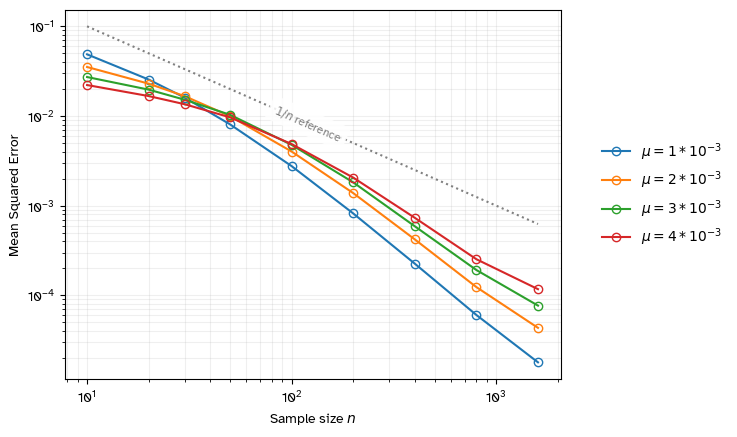

In [ ]:
def plot_coverage_accuracy(summary, factor, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))
    ax.loglog(summary["n"], summary["mse"], marker="o", 
              markerfacecolor="none", label=rf"$\mu = {factor} * 10^{{-3}}$")
    return ax, summary

fig, ax = plt.subplots()
for i, factor in enumerate(factors):
    ax, summary = plot_coverage_accuracy(accuracies[i], factor, ax=ax)

ax.loglog(summary["n"], 1 / summary["n"], color="gray", ls=":")
ax.set_xlabel("Sample size $n$")
ax.set_ylabel("Mean Squared Error")
ax.legend(frameon=False, loc="right", ncol=1, bbox_to_anchor=(1.35, 0.5))
ax.grid(True, which="both", alpha=0.2)

fig.canvas.draw()

xmin, xmax = ax.get_xlim()
lxmin, lxmax = np.log10(xmin), np.log10(xmax)
x1 = 10**(lxmin + 0.30*(lxmax - lxmin))
x2 = 10**(lxmin + 0.80*(lxmax - lxmin))

y1, y2 = 1/x1, 1/x2

p1 = ax.transData.transform((x1, y1))
p2 = ax.transData.transform((x2, y2))
angle = np.degrees(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))

x0 = 120
y0 = 1/x0

ax.text(x0, y0, r"$1/n$ reference",
        color="gray", size="small",
        ha="center", va="center",
        bbox=dict(facecolor="white", edgecolor="None", alpha=0.85),
        rotation=angle, rotation_mode="anchor",
        transform=ax.transData)

fig.savefig("../images/coverage-accuracy-2.png", dpi=300, bbox_inches="tight")

In [14]:
accuracies = []
factors = (1, 2, 3, 4)
for i, factor in enumerate(factors):
    accuracy = compute_coverage_accuracy(
        factor, exclude_f1_is_n=True, reps=100, ns=(10,20,30,50,100))
    accuracies.append(accuracy)

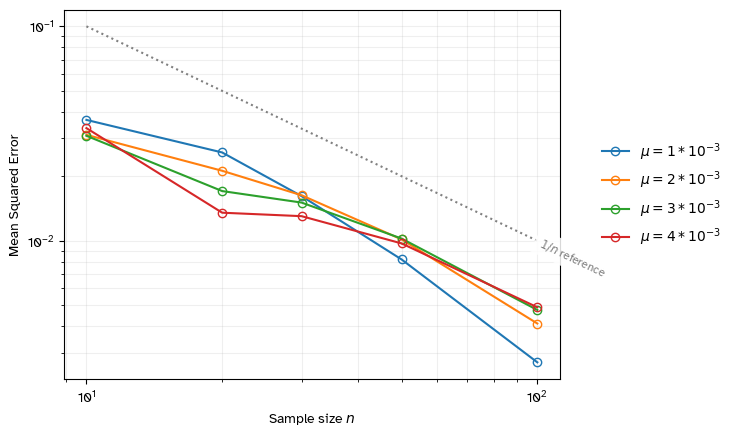

In [15]:
fig, ax = plt.subplots()
for i, factor in enumerate(factors):
    ax, summary = plot_coverage_accuracy(accuracies[i], factor, ax=ax)

ax.loglog(summary["n"], 1 / summary["n"], color="gray", ls=":")
ax.set_xlabel("Sample size $n$")
ax.set_ylabel("Mean Squared Error")
ax.legend(frameon=False, loc="right", ncol=1, bbox_to_anchor=(1.35, 0.5))
ax.grid(True, which="both", alpha=0.2)

fig.canvas.draw()

xmin, xmax = ax.get_xlim()
lxmin, lxmax = np.log10(xmin), np.log10(xmax)
x1 = 10**(lxmin + 0.30*(lxmax - lxmin))
x2 = 10**(lxmin + 0.80*(lxmax - lxmin))

y1, y2 = 1/x1, 1/x2

p1 = ax.transData.transform((x1, y1))
p2 = ax.transData.transform((x2, y2))
angle = np.degrees(np.arctan2(p2[1] - p1[1], p2[0] - p1[0]))

x0 = 120
y0 = 1/x0

ax.text(x0, y0, r"$1/n$ reference",
        color="gray", size="small",
        ha="center", va="center",
        bbox=dict(facecolor="white", edgecolor="None", alpha=0.85),
        rotation=angle, rotation_mode="anchor",
        transform=ax.transData)

fig.savefig("../images/coverage-accuracy-no-f1_is_n.png", dpi=300, bbox_inches="tight")

In [ ]:
import numpy as np
import seaborn as sns

def expected_C(factor, n):
    theta = 2 * 10**4 * (factor * 10**-3)
    return n / (n + theta) 

ns = 10, 20, 30
mu_factors = 1, 2, 3, 4
reps = 100

dfs = []

for factor in mu_factors:
    _factor = 2 if factor == 1 else factor
    with open(f"../data/threshold_populations1-{_factor}.pkl", "rb") as f:
        populations = pickle.load(f)

    df = eval_coverage_accuracy(populations, factor, ns=ns, reps=reps)
    df["mu_factor"] = factor
    df["mu_label"] = rf"{factor} * 10^{{-3}}"
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

long = df_all.melt(
    id_vars=["n", "mu_factor", "mu_label"],
    value_vars=["C_true", "C_hat"],
    var_name="kind", value_name="coverage"
)

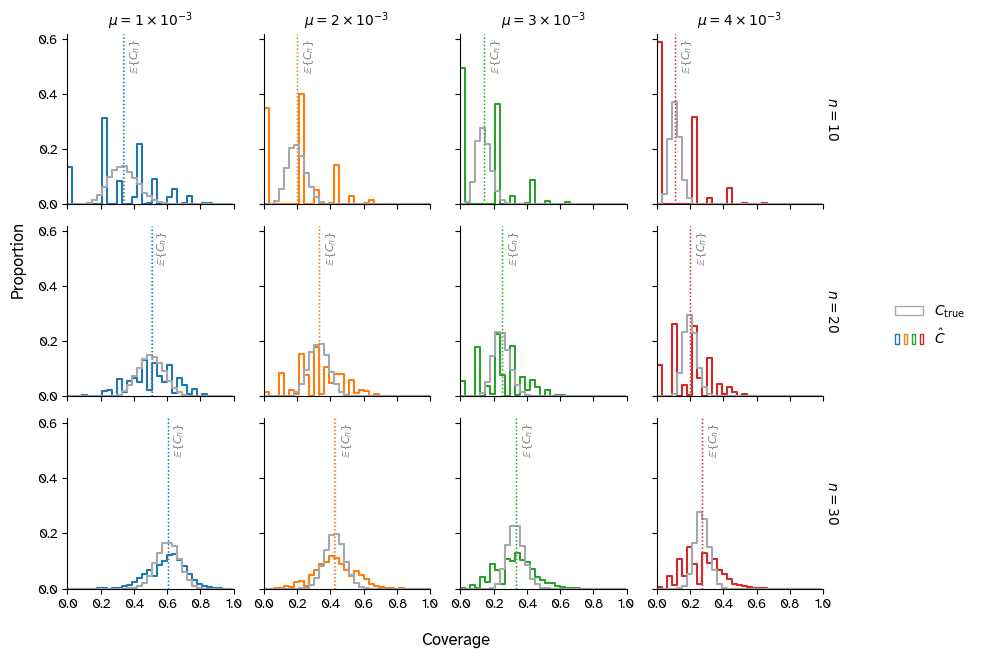

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
plt.style.use('default')

p = plt.rcParams
p["font.sans-serif"] = ["Atkinson Hyperlegible"]
p["font.weight"] = "light"

g = sns.FacetGrid(
    long, row="n", col="mu_factor",
    sharex=True, sharey=True,
    margin_titles=True,
    height=2.2, aspect=1.1
)

bins = np.arange(0, 1.0001, 0.03)

def overlay_hist(data, **kws):
    factor = data["mu_factor"].iloc[0]
    palette = {"C_true": "#A5A9AB", "C_hat": f"C{factor - 1}"}
    ax = plt.gca()
    sns.histplot(
        data=data, x="coverage", hue="kind",
        bins=bins, stat="proportion", common_norm=False,
        element="step", fill=False,
        palette=palette, legend=False, ax=ax
    )

    n = data["n"].iloc[0]
    C_exp = expected_C(factor, n)

    C_true_mean = data.loc[data["kind"] == "C_true", "coverage"].mean()
    C_hat_mean = data.loc[data["kind"] == "C_hat", "coverage"].mean()

    ax.axvline(C_true_mean, color=palette["C_true"], linestyle=":", linewidth=1)
    ax.axvline(C_hat_mean, color=palette["C_hat"], linestyle=":", linewidth=1)

    ax.text(
        C_exp + 0.03, 0.6,
        r"$\mathbb{E}\{C_{n}\}$", color="gray", fontsize=8,
        rotation=90, va="top", ha="left"
    )

g.map_dataframe(overlay_hist)

g.set_axis_labels("", "")
g.set(xlim=(0, 1), xticks=np.linspace(0, 1, 6))
g.set_titles(col_template=r"$\mu = {col_name:.0f} \times 10^{{-3}}$", 
             row_template=r"$n = {row_name:.0f}$")

g.figure.supylabel("Proportion", y=0.6)
g.figure.supxlabel("Coverage", x=0.48)

hat_colors = [f"C{i}" for i in range(4)]
true_color = "#A5A9AB"

class MultiColorPatch:
    def __init__(self, colors):
        self.colors = colors

class MultiColorHandler(HandlerPatch):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        patches = []
        n = len(orig_handle.colors)
        for i, color in enumerate(orig_handle.colors):
            rect = mpatches.Rectangle(
                [x0 + i*width/(n * 0.85), y0], width/(n*2), height,
                facecolor="none", edgecolor=color, lw=1.0,
                transform=trans
            )
            patches.append(rect)
        return patches

handles = [
    mpatches.Patch(facecolor='none', edgecolor=true_color, label=r"$C_{\mathrm{true}}$"),
    MultiColorPatch(hat_colors)
]

labels = [r"$C_{\mathrm{true}}$", r"$\hat{C}$"]

g.figure.legend(
    handles=handles, labels=labels,
    handler_map={MultiColorPatch: MultiColorHandler()},
    loc="center right", bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

g.figure.tight_layout()
g.figure.subplots_adjust(right=0.86)
g.figure.savefig("../images/hist-covs-grid-correct.png", dpi=300, bbox_inches="tight")

In [ ]:
mu_factors = [1, 2, 3, 4]
ns_line = list(range(10, 201, 10))
reps_line = 100

summaries = {}

for factor in mu_factors:
    _factor = 2 if factor == 1 else factor
    with open(f"../data/threshold_populations1-{_factor}.pkl", "rb") as f:
        populations = pickle.load(f)

    df = eval_coverage_accuracy(populations, factor, ns=ns_line, reps=reps_line)
    df["mu_factor"] = factor
    df["mu_label"] = rf"{factor} \times 10^{{-3}}"

    long = df.melt(
        id_vars=["n", "mu_factor", "mu_label"],
        value_vars=["C_true", "C_hat"],
        var_name="kind", value_name="coverage"
    )

    def quantiles(series, qs=(0.01, 0.05, 0.25, 0.75, 0.95, 0.99)):
        q = series.quantile(qs)
        return pd.Series({
            "mean": series.mean(),
            "min": series.min(),
            "q01": q.loc[0.01],
            "q05": q.loc[0.05],
            "q25": q.loc[0.25],
            "q75": q.loc[0.75],
            "q95": q.loc[0.95],
            "q99": q.loc[0.99],
            "max": series.max()
        })

    summary = (
        long
        .groupby(["n", "kind"])["coverage"]
        .apply(quantiles)
        .unstack()
        .reset_index()
    )

    summaries[factor] = summary


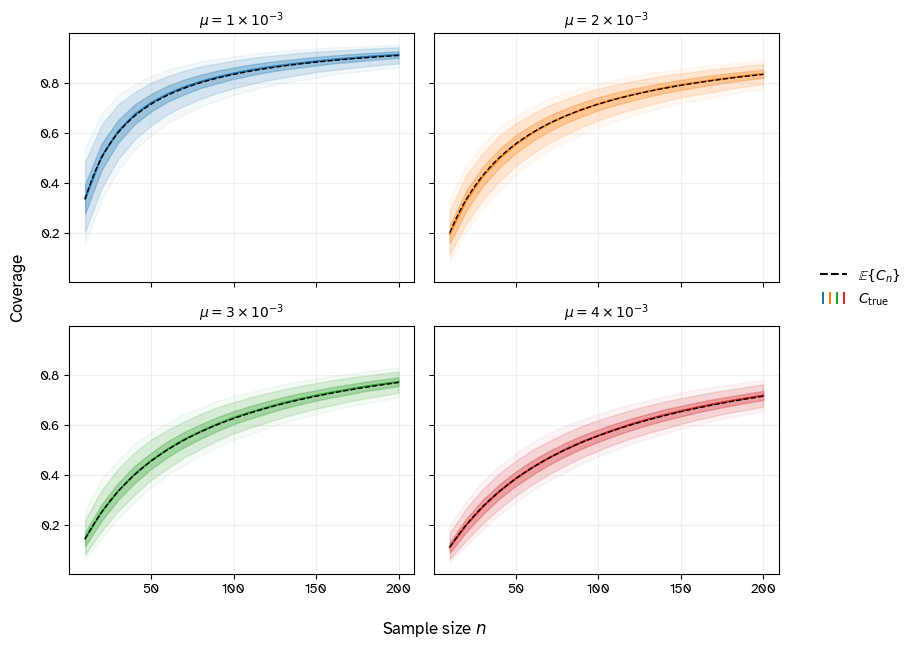

In [ ]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 2, figsize=(8, 6.5), sharex=True, sharey=True)
axes = axes.flatten()

hat_color = "C0"

for i, (ax, factor) in enumerate(zip(axes, mu_factors)):
    summary = summaries[factor]

    sub = summary[summary["kind"] == "C_true"]
    ax.plot(sub["n"], sub["mean"], color=f"C{i}", lw=1.5)
    ax.fill_between(sub["n"], sub["q01"], sub["q99"], alpha=0.05, color=f"C{i}")
    ax.fill_between(sub["n"], sub["q05"], sub["q95"], alpha=0.15, color=f"C{i}")
    ax.fill_between(sub["n"], sub["q25"], sub["q75"], alpha=0.30, color=f"C{i}")

    n_grid = np.arange(10, 201)
    ax.plot(
        n_grid,
        expected_C(factor, n_grid),
        linestyle="--",
        color="black",
        lw=1.0)
    ax.grid(alpha=0.2)

    ax.set_title(rf"$\mu = {factor} \times 10^{{-3}}$", fontsize=10)

fig.supxlabel(r"Sample size $n$", x=0.55)
fig.supylabel("Coverage", y=0.55)


class MultiColorLines:
    def __init__(self, colors):
        self.colors = colors

class MultiColorLineHandler(HandlerPatch):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        artists = []
        n = len(orig_handle.colors)

        for i, color in enumerate(orig_handle.colors):
            x = x0 + (i + 0.5) * width / n 
            line = Line2D(
                [x, x], 
                [y0, y0 + height],
                color=color,
                linewidth=1.5,
                transform=trans,
            )
            artists.append(line)

        return artists
    
hat_colors = ["C0", "C1", "C2", "C3"]

handles = [
    Line2D([], [], color="black", ls="--", linewidth=1.5, label=r"$\mathbb{E}\{C_n\}$"),
    MultiColorLines(hat_colors)
]

labels = [r"$\mathbb{E}\{C_n\}$", r"$C_{\text{true}}$"]

fig.legend(
    handles=handles, labels=labels,
    handler_map={MultiColorLines: MultiColorLineHandler()},
    loc="center right",
    ncol=1,
    frameon=False,
    bbox_to_anchor=(1.15, 0.55)
)

fig.tight_layout()
fig.savefig("../images/coverage-vs-n-grid.png", dpi=300, bbox_inches="tight")